In [1]:
from scipy import stats
from scipy.special import gamma
from scipy.stats import expon
import numpy as np
np.seterr(divide='ignore', invalid='ignore')
import math
from matplotlib import pyplot as plt
%matplotlib inline
import corner
from glob import glob
import os

In [10]:
def mu_lgprior(mu, sigma):
    return 0


def mu_lglike(samples, mu, sigma):
    return -np.sum((samples - mu)**2) / (2 * sigma**2)


# log-posterior for P(mu | sigma, samples)
def mu_lgprob(mu, sigma, samples):
    # l(mu | sigma, samples) ~ l(mu, sigma) + l(samples | mu, sigma)
    return mu_lgprior(mu, sigma) + mu_lglike(samples, mu, sigma)


def get_mu(mu, sigma, samples):
    # Draw new mu from proposal distribution 
    new_mu = np.random.uniform(low=0, high=4.0)
    
    prob_new_mu = 1. / 4.
    prob_old_mu = 1. / 4.
    
    # MH-Step
    # a = a_1 * a_2
    # a_1 = P(new) / P(old)
    # a_2 = Q(old) / Q(new)
    # Accept with prob a if a <= 1
    # lg(a) = lg(a_1) + lg(a2)
    # lg(a) = lg(P(new)) - lg(P(old)) + lg(Q(old)) - lg(Q(new))
    # Accept with prob a if lg(a) <= 0
    
    lg_a1 = mu_lgprob(new_mu, sigma, samples) - mu_lgprob(mu, sigma, samples)
    
    lg_a2 = math.log(prob_old_mu) - math.log(prob_new_mu)
    
    lg_a = lg_a1 + lg_a2

    if lg_a > 1:
        return new_mu
    else:
        lg_r = math.log(np.random.uniform())
        if lg_r < lg_a:
            return new_mu
        else:
            return mu

In [11]:
def sigma_lgprior(mu, sigma):
    return 0


def sigma_lglike(samples, mu, sigma):
    return -len(samples) * math.log(sigma) - np.sum((samples - mu)**2) / (2 * sigma**2)


# log-posterior for P(mu | sigma, samples)
def sigma_lgprob(mu, sigma, samples):        
    # l(sigma | mu, samples) ~ l(mu, sigma) + l(samples | mu, sigma)
    return sigma_lgprior(mu, sigma) + sigma_lglike(samples, mu, sigma)


def get_sigma(mu, sigma, samples):    
    # Draw new sigma from proposal distribution
    new_sigma = np.random.uniform(low=0, high=5)
    
    prob_new_sigma = 1. / 5.
    prob_old_sigma = 1. / 5.
    
    # MH-Step
    # a = a_1 * a_2
    # a_1 = P(new) / P(old)
    # a_2 = Q(old) / Q(new)
    # Accept with prob a if a <= 1
    # lg(a) = lg(a_1) + lg(a2)
    # lg(a) = lg(P(new)) - lg(P(old)) + lg(Q(old)) - lg(Q(new))
    # Accept with prob a if lg(a) <= 0
    
    lg_a1 = sigma_lgprob(mu, new_sigma, samples) - sigma_lgprob(mu, sigma, samples)
        
    lg_a2 = math.log(prob_old_sigma) - math.log(prob_new_sigma)
            
    lg_a = lg_a1 + lg_a2

    if lg_a > 0:
        return new_sigma
    else:
        lg_r = math.log(np.random.uniform())
        if lg_r < lg_a:
            return new_sigma
        else:
            return sigma

In [22]:
def load_data():
    ret_data = []
    
    pulsars = glob("../pars_M2_SINI/*")
    for pulsar in pulsars:
        chain = os.path.join(pulsar, "chain_burn_0.5_thin_10.txt")
        chain_data = np.genfromtxt(chain)
        m1_data = chain_data[:, 3]
        ret_data.append(m2_data)
        
    return np.asarray(ret_data)

In [23]:
def thin_data(measurements, num_points=5000):
    ret_data = []

    for measurement in measurements:
        if len(measurement) < num_points:
            ret_data.append(measurement)
            continue
        ret_data.append(measurement[::int(len(measurement) / num_points)])
        
    return np.asarray(ret_data)

In [24]:
m1_vals = load_data()

In [7]:
def get_samples(mu, sigma, measurements):
    guess = stats.norm(loc=mu, scale=sigma)
    # Draw new samples from P(M2_i | mu, sigma)
    N = measurements.shape[0]
    samples = np.zeros(N)
    
    for i, measurement in enumerate(measurements):
        probs = guess.pdf(measurement)
        probs /= np.sum(probs)
        samples[i] = np.random.choice(measurement, p=probs)
    
    return samples

In [8]:
def sample(measurements, niter=1000, guess_mu=1.0, guess_sigma=1.0):
    mus = np.zeros(niter)
    sigmas = np.zeros(niter)
    
    mus[0] = guess_mu
    sigmas[0] = guess_sigma

    # Gibbs Sampling
    for i in range(1, niter):
        if i % 100 == 0:
            print "{0:0.1f}% Done                   \r".format(100. * i / float(niter)),

        # Draw x_i ~ P(x_i | mu_i-1, sigma_i-1)
        samples = get_samples(mus[i - 1], sigmas[i - 1], measurements)
        
        # Draw mu_i ~ P(mu_i | x_i, sigma_i-1)
        mus[i] = get_mu(mus[i - 1], sigmas[i - 1], samples)
        
        # Draw sigma_i ~ P(sigma_i | x_i, mu_i)
        sigmas[i] = get_sigma(mus[i], sigmas[i - 1], samples)
    
    return mus, sigmas

In [33]:
thinned_data = thin_data(m1_vals)
mus, sigmas = sample(thinned_data, niter=100000)

In [43]:
def plot_sampling(measurements, mus, sigmas, pop_mu, pop_sigma, burn_in=0.5, thin=0.1):
    mus_good = mus[int(burn_in * len(mus))::int(1/thin)]
    sigmas_good = sigmas[int(burn_in * len(sigmas))::int(1/thin)]

    best_guess_mu = np.median(mus_good)
    best_guess_sigma = np.median(sigmas_good)
    
    n, bins, _ = plt.hist([np.median(measurement) for measurement in measurements], normed=True, label="Data")
    x = np.linspace(bins[0], bins[-1], 100)
    
    plt.plot(x, stats.norm(loc=best_guess_mu, scale=best_guess_sigma).pdf(x), label="Guess")
    plt.legend()
    plt.tight_layout()
    plt.show()
    
    mu_sigma_corner = np.vstack((mus_good, sigmas_good)).T
    try:
        figure = corner.corner(mu_sigma_corner, quantiles=[0.16, 0.5, 0.84])
        ndim = 2

        if pop_mu is not None and pop_sigma is not None:
            # Extract the axes
            axes = np.array(figure.axes).reshape((ndim, ndim))

            value1 = np.asarray([pop_mu, pop_sigma])

            # Loop over the diagonal
            for i in range(ndim):
                ax = axes[i, i]
                ax.axvline(value1[i], color="g")

            # Loop over the histograms
            for yi in range(ndim):
                for xi in range(yi):
                    ax = axes[yi, xi]
                    ax.axvline(value1[xi], color="g")
                    ax.axhline(value1[yi], color="g")
                    ax.plot(value1[xi], value1[yi], "sg")
    except:
        print "Cannot corner plot"
    plt.show()

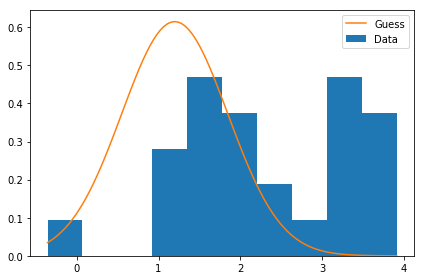

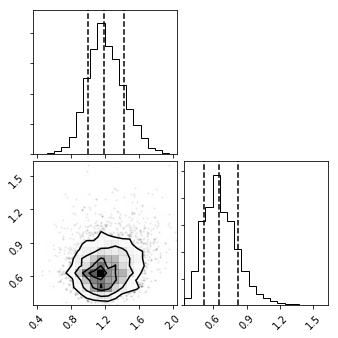

In [44]:
plot_sampling(thinned_data, mus, sigmas, None, None)

In [45]:
def load_data_2():
    ret_data = []
    
    pulsars = glob("../../AAS/thinned_chains/pars_M2_SINI/*")
    for pulsar in pulsars:
        chain = os.path.join(pulsar, "chain_burn_0.5_thin_10.txt")

        length = 0
        with open(chain, 'r') as infile:
            for line in infile:
                length += 1
        
        cosi_data = np.zeros(length)

        lines = open(chain).readlines()
        for i, line in enumerate(lines):
            cosi_data[i] = float(line.split()[2])
        
        i = 0
        with open(chain, 'r') as infile:
            for line in infile:
                cosi = float(line.split()[2])
                cosi_data[i] = cosi
                i += 1
        
        ret_data.append(cosi_data)
        
    return np.asarray(ret_data)

In [46]:
%timeit load_data_2()

1 loop, best of 3: 25 s per loop


In [180]:
%timeit load_data()

1 loop, best of 3: 1min 19s per loop


(array([ 1.,  0.,  0.,  1.,  0.,  0.,  1.,  0.,  0.,  1.]),
 array([ 0. ,  0.3,  0.6,  0.9,  1.2,  1.5,  1.8,  2.1,  2.4,  2.7,  3. ]),
 <a list of 10 Patch objects>)

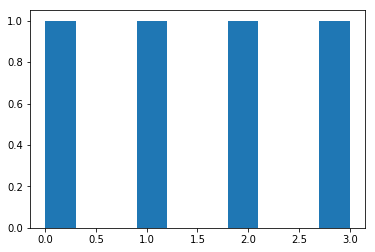

In [42]:
plt.hist([0, 1, 2, 3])